В рамках экспериментов были обучены модели LeNet-5, ResNet-20, ResNet-18 со следущими функциями активации: ReLU, ReLU6, Hardtanh, ReLU с обучаемой верхней границей, Hardtanh с обучаемыми обеими границами. Сначала обучались полноразмерные модели на 120 эпохах. Затем производилось квантование до различных размерностей (4, 3 и 2 бита) посредством QAT с дообучением на 60 эпох (при этом первый и последний слой не квантовались).

### Построение "сырых" графиков
В папке `plots/` собраны графики для каждой модели отдельно, в подпапке `activations/` - гистограммы с распределением активаций для каждого слоя, в подпапке `training/` - графики с процесса обучения, в `activations_parameters/` - динамика обучаемых параметров у соответствующих функций активации

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_histograms_and_scalars(logs_dir='raw_np', plots_dir='plots', bins=50):
    """
    Generate bar histograms for activations and line plots for training statistics.
    """
    # Ensure plots directory exists
    os.makedirs(plots_dir, exist_ok=True)
    
    # Iterate through each model directory in logs
    for model_name in os.listdir(logs_dir):
        model_log_dir = os.path.join(logs_dir, model_name)
        if not os.path.isdir(model_log_dir):
            continue
            
        # Create model-specific plot directories
        model_plot_dir = os.path.join(plots_dir, model_name)
        activations_plot_dir = os.path.join(model_plot_dir, 'activations')
        scalars_plot_dir = os.path.join(model_plot_dir, 'training')
        act_params_plot_dir = os.path.join(model_plot_dir, 'activations_parameters')
        os.makedirs(activations_plot_dir, exist_ok=True)
        os.makedirs(scalars_plot_dir, exist_ok=True)
        os.makedirs(act_params_plot_dir, exist_ok=True)
        
        # Plot histograms for activations
        acts_dir = os.path.join(model_log_dir, 'activations')
        for file in os.listdir(acts_dir):
            if file.endswith('.npz'):
                file_path = os.path.join(acts_dir, file)
                data = np.load(file_path)
                act = data["activations"]
                params = data["params"]
                layer_name = file.split('_')[0]
                epoch = file.split('_')[2].split('.')[0]
                
                plt.figure(figsize=(8, 6))
                plt.hist(act.flatten(), bins=bins, density=True)
                subtitle = f"\nLearnable parameters values = {", ".join(f"{x:.6f}" for x in params)}" if params.size >= 1 else ""
                plt.title(f'Activation Histogram for {layer_name} at Epoch {epoch}{subtitle}\n{model_name}')
                plt.xlabel('Activation Value')
                plt.ylabel('Density')
                plt.grid(True, alpha=0.3)
                plt.savefig(os.path.join(activations_plot_dir, f'{layer_name}_epoch_{epoch}.png'))
                plt.close()
                if "quant" in model_name:
                    a = np.unique(act.flatten())
                    print(f"[{model_name}] Unique activations of {layer_name} at Epoch {epoch} - {len(a)}:", a)

        # Plot training statistics
        scalars_file = os.path.join(model_log_dir, 'training_stats.npz')
        if os.path.exists(scalars_file):
            data = np.load(scalars_file)
            epochs = data['epoch']
            
            # Plot losses
            plt.figure(figsize=(8, 6))
            plt.plot(epochs, data['train_loss'], label='Train Loss')
            plt.plot(epochs, data['eval_loss'], label='Eval Loss')
            plt.title(f'Losses vs. Epoch\n{model_name}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.savefig(os.path.join(scalars_plot_dir, 'losses.png'))
            plt.close()
            
            # Plot accuracies
            plt.figure(figsize=(8, 6))
            plt.plot(epochs, data['train_acc'], label='Train Accuracy')
            plt.plot(epochs, data['eval_acc'], label='Eval Accuracy')
            plt.title(f'Accuracies vs. Epoch\n{model_name}')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.savefig(os.path.join(scalars_plot_dir, 'accuracies.png'))
            plt.close()
            
            # Plot learning rate
            plt.figure(figsize=(8, 6))
            plt.plot(epochs, data['learning_rate'], label='Learning Rate')
            plt.title(f'Learning Rate vs. Epoch\n{model_name}')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.savefig(os.path.join(scalars_plot_dir, 'learning_rate.png'))
            plt.close()

        # Plot activations parameters dynamic
        act_params_stat_dir = os.path.join(model_log_dir, 'activations_parameters')
        if os.path.isdir(act_params_stat_dir):
            for file in os.listdir(act_params_stat_dir):
                file_path = os.path.join(act_params_stat_dir, file)
                data = np.load(file_path)
                if data is None or data.size == 0:
                    continue
                
                if data[0].size == 1:
                    alphas = data[:, 0]
                    betas = None
                else:
                    betas = data[:, 0]
                    alphas = data[:, 1]

                layer_name = file.removesuffix(".npy")
                
                
                # Plot params
                plt.figure(figsize=(8, 6))
                plt.plot(epochs, alphas, label='Alpha value')
                if betas is not None:
                    plt.plot(epochs, betas, label='Beta value')
                plt.title(f'Parameters vs. Epoch for {layer_name}\n{model_name}')
                plt.xlabel('Epoch')
                plt.ylabel('Value')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.savefig(os.path.join(act_params_plot_dir, f'{layer_name}.png'))
                plt.close()
            
plot_histograms_and_scalars()

In [21]:
%matplotlib inline

### Анализ непараметризованных функций активации

Сравним и проанализируем результаты, полученные при обучении моделей с ReLU, ReLU6 и Hardtanh.

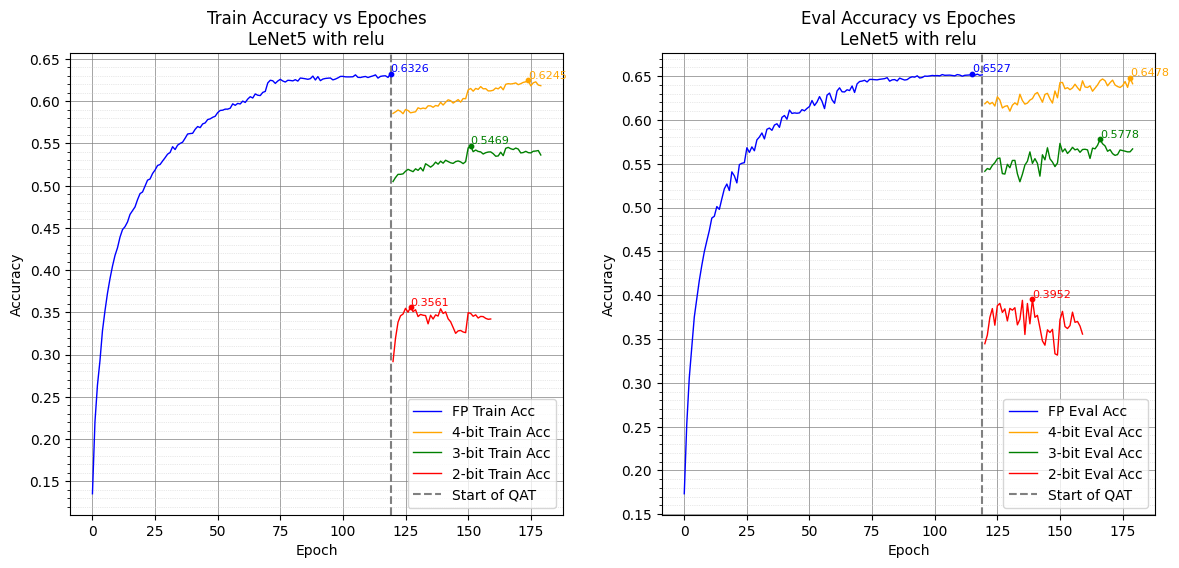

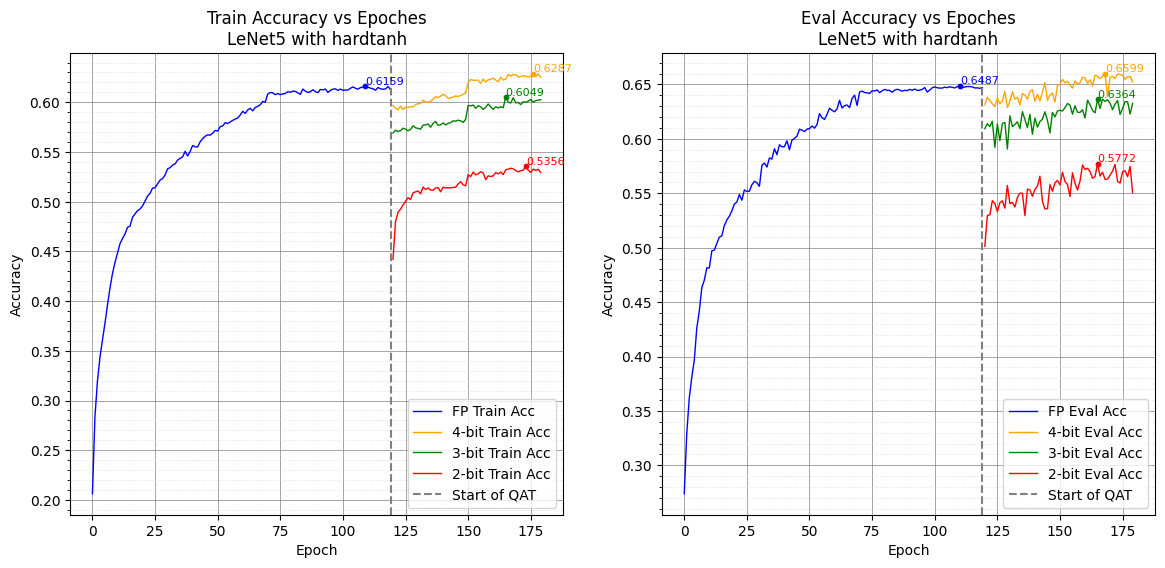

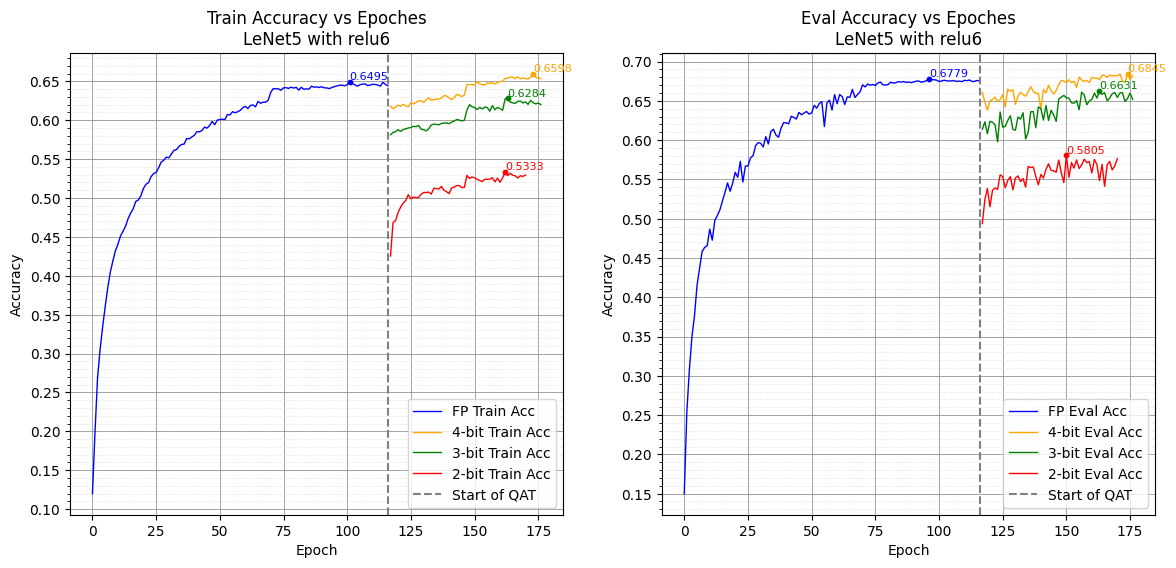

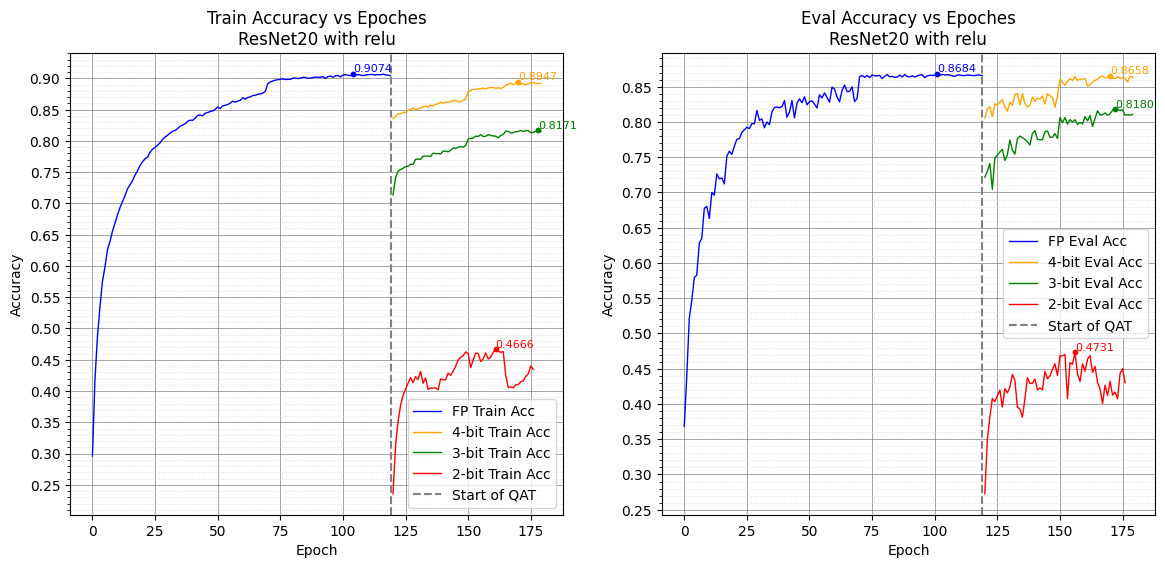

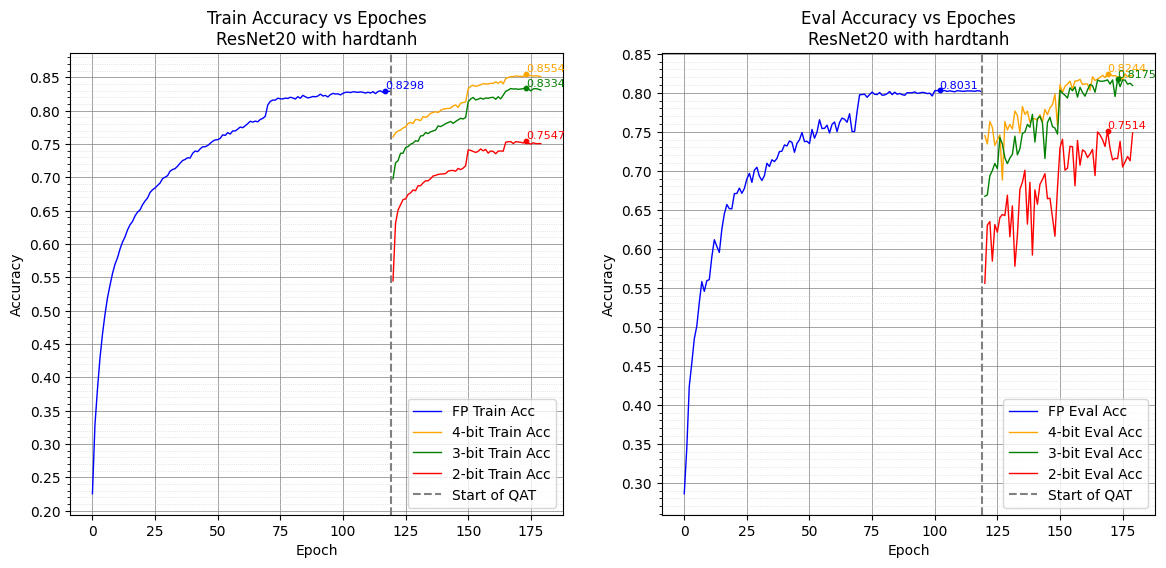

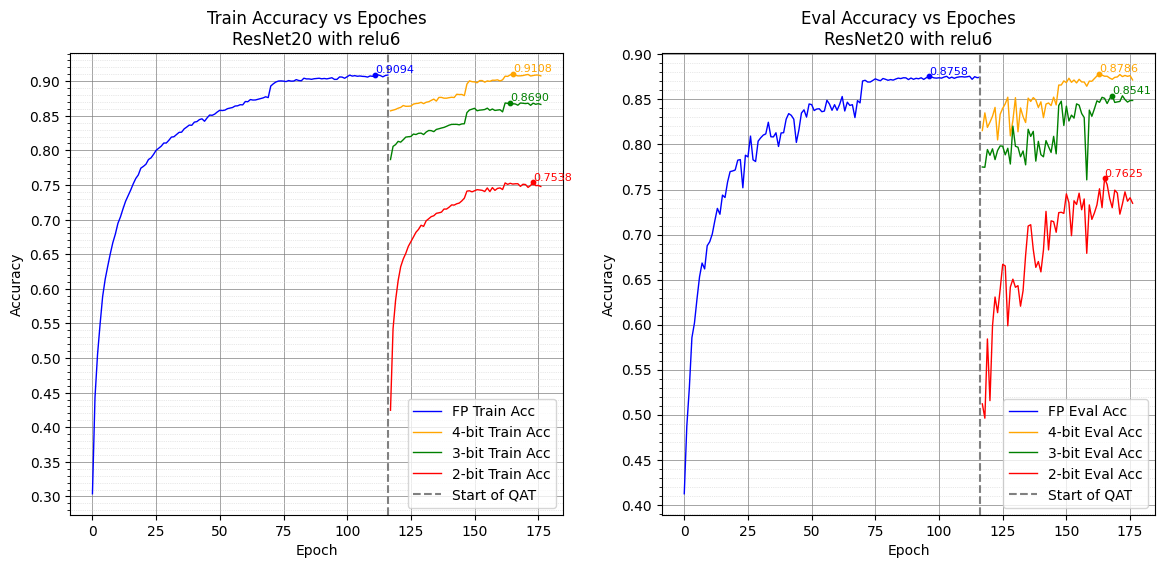

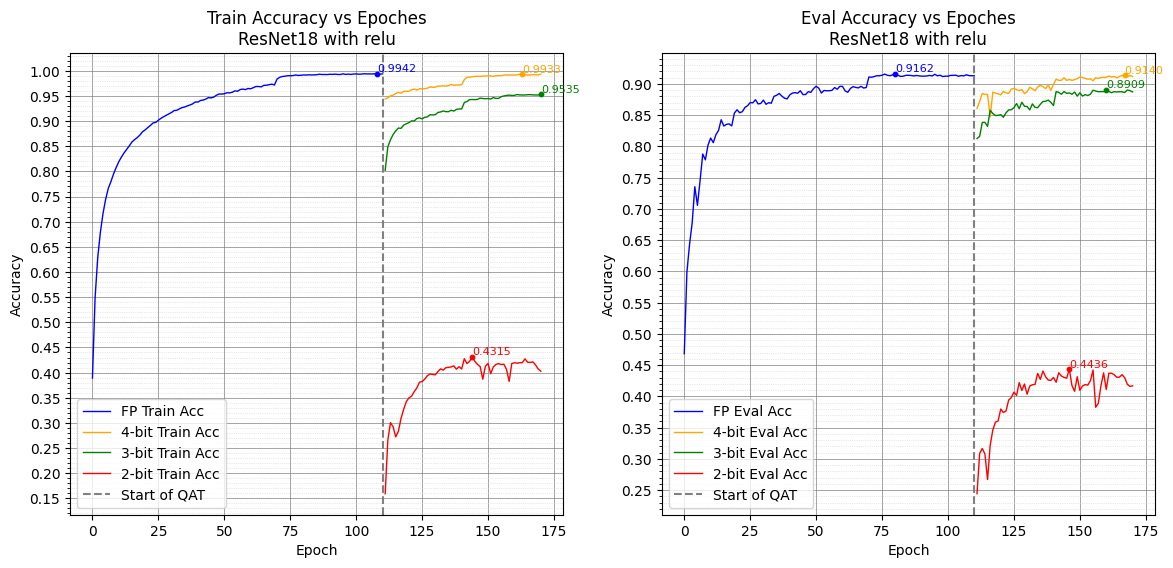

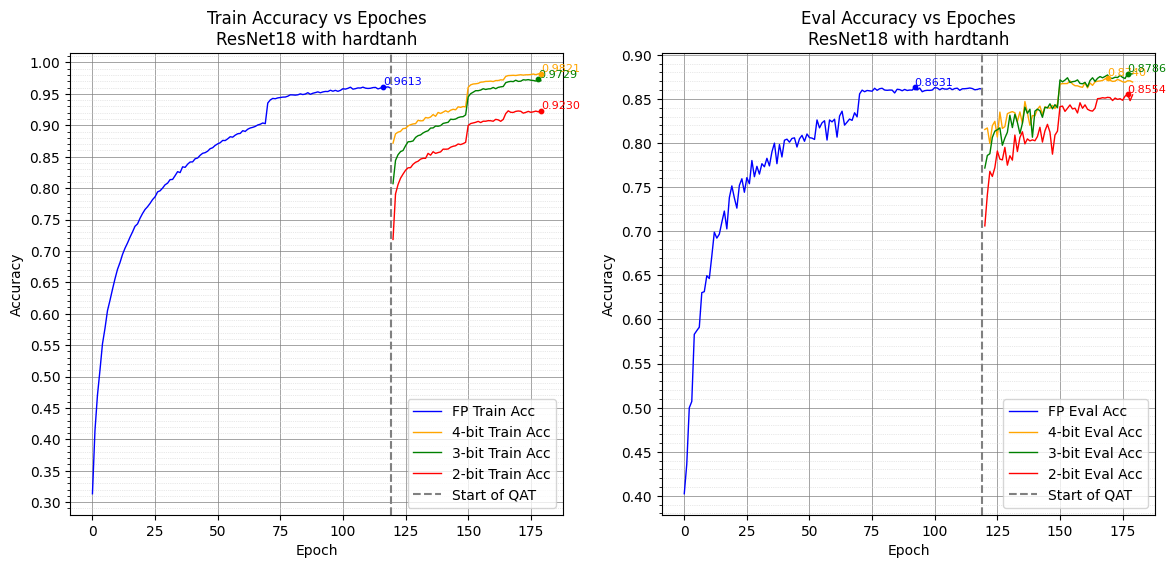

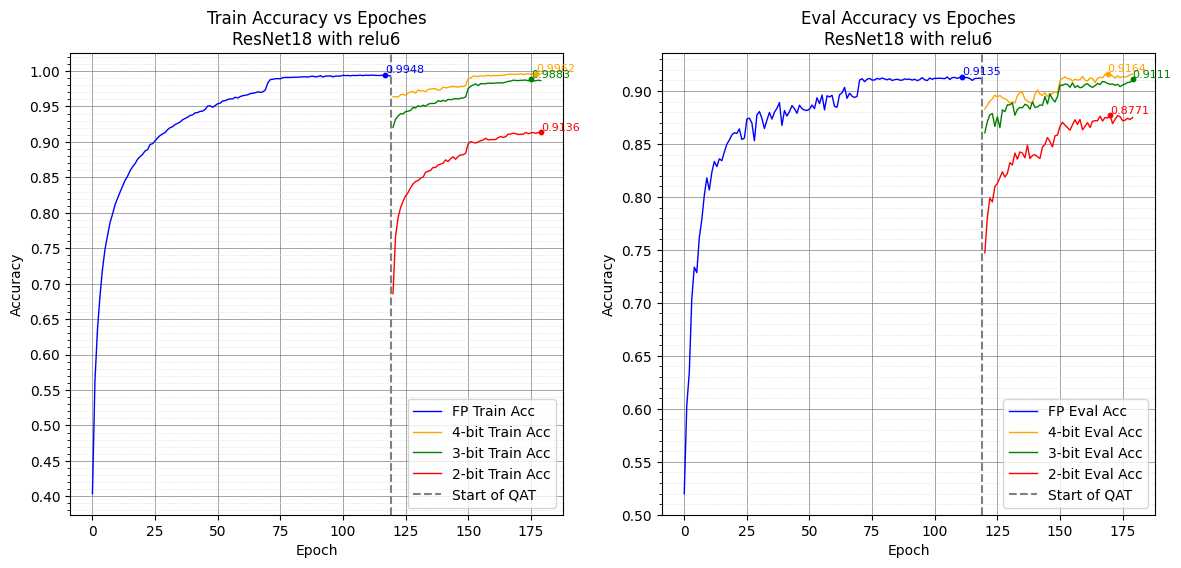

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


def highlight_maximum_point(ax, metric, epochs, color):
    max_ind = np.argmax(metric)

    ax.scatter(
        epochs[max_ind],
        metric[max_ind],
        color=color,
        s=10,
        zorder=5,
    )
    ax.text(
        epochs[max_ind],
        metric[max_ind],
        f"{metric[max_ind]:.4f}",
        fontsize=8,
        ha="left",
        va="bottom",
        color=color,
    )


def plot_comparisons(
    logs_dir="raw_np",
    activations=["relu", "hardtanh", "relu6"],
    colors=["orange", "green", "red"],
):
    architectures = ["LeNet5", "ResNet20", "ResNet18"]
    bit_widths = [4, 3, 2]

    for arch in architectures:
        for act in activations:
            # FP model stats

            # We are training Parametrized Acts Models from other Acts
            if act == "parametrized_relu":
                fp_model_act = "relu6"
            elif act == "parametrized_hardtanh":
                fp_model_act = "hardtanh"
            else:
                fp_model_act = act

            fp_file = os.path.join(logs_dir, f"{arch}_{fp_model_act}", "training_stats.npz")
            if not os.path.exists(fp_file):
                print(f"File {fp_file} was not found.")
                continue
            fp_data = np.load(fp_file)
            fp_eval_acc = fp_data["eval_acc"]
            fp_train_acc = fp_data["train_acc"]

            fp_epochs = fp_data["epoch"]
            last_fp_epoch = fp_epochs[-1]  # Last epoch of FP training

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

            ax1.plot(
                fp_epochs, fp_train_acc, label="FP Train Acc", color="blue", linewidth=1
            )
            ax2.plot(
                fp_epochs, fp_eval_acc, label="FP Eval Acc", color="blue", linewidth=1
            )

            highlight_maximum_point(ax1, fp_train_acc, fp_epochs, color="blue")
            highlight_maximum_point(ax2, fp_eval_acc, fp_epochs, color="blue")

            # Quantized models plots
            for bits, color in zip(bit_widths, colors):
                quant_file = os.path.join(
                    logs_dir,
                    f"{arch}_{act}_quantized_{bits}_bits",
                    "training_stats.npz",
                )
                if os.path.exists(quant_file):
                    quant_data = np.load(quant_file)
                    quant_epochs = (
                        quant_data["epoch"] + last_fp_epoch + 1
                    )  # Shift QAT epochs
                    quant_eval_acc = quant_data["eval_acc"]
                    quant_train_acc = quant_data["train_acc"]
                    ax1.plot(
                        quant_epochs,
                        quant_train_acc,
                        label=f"{bits}-bit Train Acc",
                        color=color,
                        linewidth=1,
                    )
                    ax2.plot(
                        quant_epochs,
                        quant_eval_acc,
                        label=f"{bits}-bit Eval Acc",
                        color=color,
                        linewidth=1,
                    )

                    highlight_maximum_point(
                        ax1, quant_train_acc, quant_epochs, color=color
                    )
                    highlight_maximum_point(
                        ax2, quant_eval_acc, quant_epochs, color=color
                    )
                else:
                    print(f"File {quant_file} was not found.")

            ax1.set_title(f"Train Accuracy vs Epoches\n{arch} with {act}")
            ax2.set_title(f"Eval Accuracy vs Epoches\n{arch} with {act}")
            for ax in [ax1, ax2]:
                ax.set_xlabel("Epoch")
                ax.set_ylabel("Accuracy")

                ax.yaxis.set_major_locator(MultipleLocator(0.05))
                ax.yaxis.set_minor_locator(MultipleLocator(0.01))
                ax.grid(which="major", linestyle="-", linewidth=0.5, color="gray")
                ax.grid(which="minor", linestyle=":", linewidth=0.5, color="lightgray")
                # Add vertical line to mark transition from FP to QAT
                ax.axvline(
                    x=last_fp_epoch, color="gray", linestyle="--", label="Start of QAT"
                )
                ax.legend(loc="best", fontsize=10)

            plt.show()


plot_comparisons(logs_dir="raw_np")

Можно отметить, что среди полноразмерных моделей точности ReLU и ReLU6 примерно совпадают (ReLU начинает доминировать с ростом размера модели) и превосходят Hardtanh. Но стоит отметить, что модели с Hardtanh лучше остальных активаций "закрывают зазор" с полноразмерной моделью при QAT (возможные причины: симметричность функции и меньший диапазон значений). Все модели смогли восстановить точность/превзойти точность исходной модели при квантовании до 4 бит (при этом модели с Hardtanh также обгоняют исходную и при квантовании до 3 бит). При этом эффективность квантования увеличивается с ростом сложности модели. Превышение точности полноразмерной модели можно объяснить "регуляризацией", которую вносит процесс квантования (или же полноразмерные модели вышли недообученными?). 
Отмечу, что ReLU6 дает лучшие результаты среди непараметризованных моделей (благодаря высокой точности модели и эффективности последующего квантования).
При этом, ReLU хуже всего подходит для квантования - выходят большие зазоры с моделями, квантованными до 4 и 3 бит, и при квантовании до 2 бит модель не может восстановится. Это можно объяснить неограниченностью ReLU сверху, что приводит к слишком большому шагу квантования. (Ниже приведены гистограммы с распределениями значений активаций до и после квантования для ReLU)

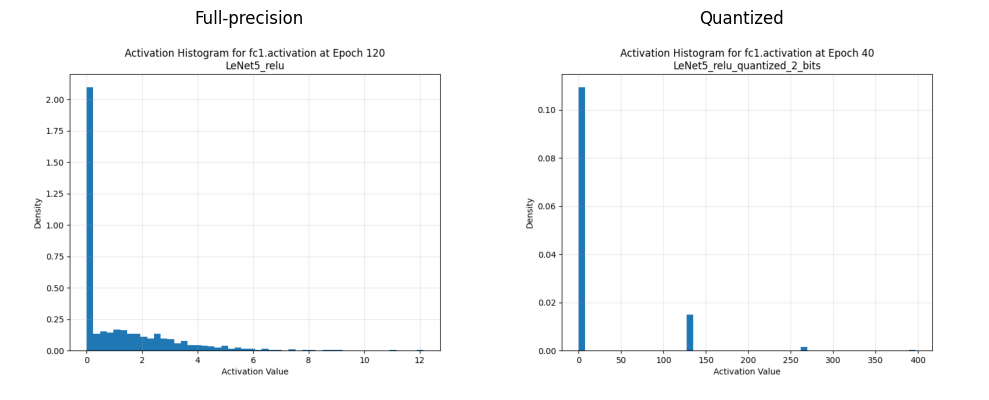

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


fp  = mpimg.imread('plots/LeNet5_relu/activations/fc1.activation_epoch_120.png')
quant = mpimg.imread('plots/LeNet5_relu_quantized_2_bits/activations/fc1.activation_epoch_40.png')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(fp)
axes[0].set_title('Full-precision')
axes[0].axis('off')

axes[1].imshow(quant)
axes[1].set_title('Quantized')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Параметризованные функции активации

Были рассмотрены две функции активации
$$
\mathrm{ParametrizedReLU}_{\alpha}(x)
=
\begin{cases}
0, & x \le 0,\\[6pt]
x, & 0 < x < \alpha,\\[6pt]
\alpha, & x \ge \alpha.
\end{cases}
$$

$$
\mathrm{ParametrizedHardtanh}_{\alpha}(x)
=
\begin{cases}
-\alpha, & x \le -\alpha,\\[6pt]
x, & -\alpha < x < \alpha,\\[6pt]
\alpha, & x \ge \alpha.
\end{cases}
$$

Введенные параметры обучались при QAT (при этом модель инициализировалась непараметризованной полноразмерной: для ParametrizedReLU были использованы модели с ReLU6, для ParametrizedHardtanh - модели с Hardtanh). Стартовые значения параметров у активаций - соответствующие значения у непараметризованных функций активации. Параметры для квантования высчитывались из обучаемого параметра (как это делали в статье про PACT). То есть, имеют следующий вид:
- Для `ParametrizedReLU`:
$$
\mathrm{scale}
=\frac{\alpha}{2^\mathrm{num\_bits} - 1}
$$

$$
\mathrm{zero\_point}=0
$$

- Для `ParametrizedHardtanh`:
$$
\mathrm{scale}
=\frac{2\alpha}{2^\mathrm{num\_bits} - 1}
$$

$$
\mathrm{zero\_point}=0
$$

Отмечу также, что для `ParametrizedHardtanh` было использовано симметричное квантование (т.е. количество возможных значений активации: $2^\mathrm{num\_bits} - 1$), чтобы гарантировать совпадение концов отрезка ($[-\alpha, \alpha]$) до и после квантования. При попытках аффинного квантования возникала нестабильность из-за несоответствия деквантованных концов отрезка - так, например, отрезок $[-1, 1]$ съезжает в $[-\frac{4}{3}, \frac{2}{3}]$ после деквантования. В результате, при введении концов отрезка как обучаемого параметра, обучение модели становиться сильно нестабильным - заметны очень большие скачки значений точности на валидационной выборке, и модель не "догоняет" соответствующую квантованную модель с обычным `Hardtanh`.
Так как при симметричном квантовании множество значений меньше, то при низкой битности (2 бита. Т.е. 3 возможных значения активации, вместо 4), можно заметить, что `ParametrizedHardtanh` проигрывает обычному. При этом, при большой битности (при которой разница в 1 возможное состояние не столь заметно), `ParametrizedHardtanh` показывает себя заметно лучше.

Модели с параметризованными активациями обучались 60 эпох с LR=0.01, уменьшающимся в 10 раз каждые 15 эпох.

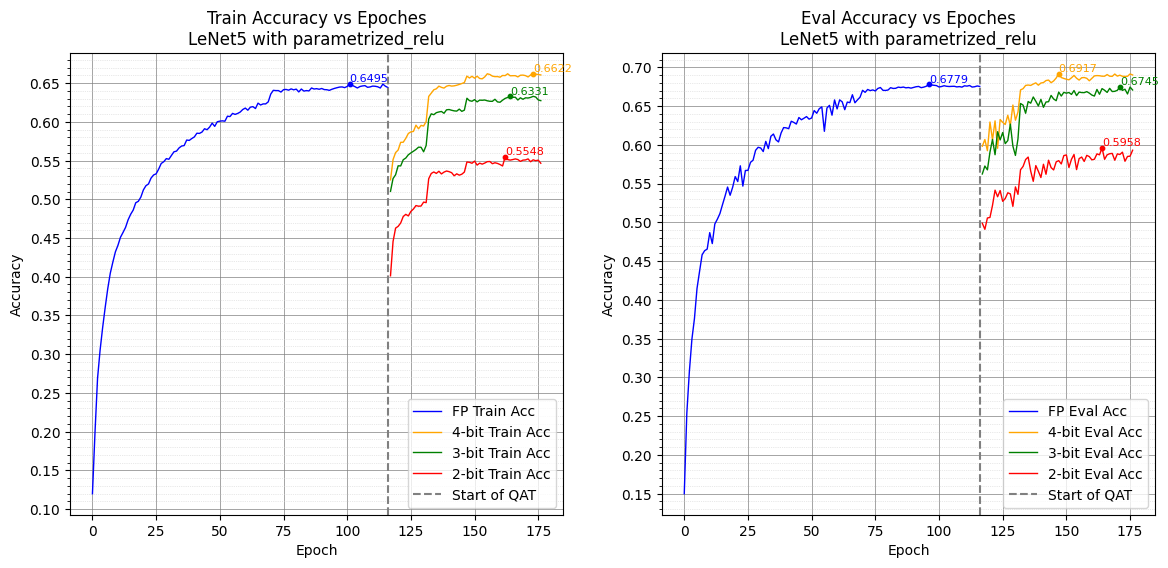

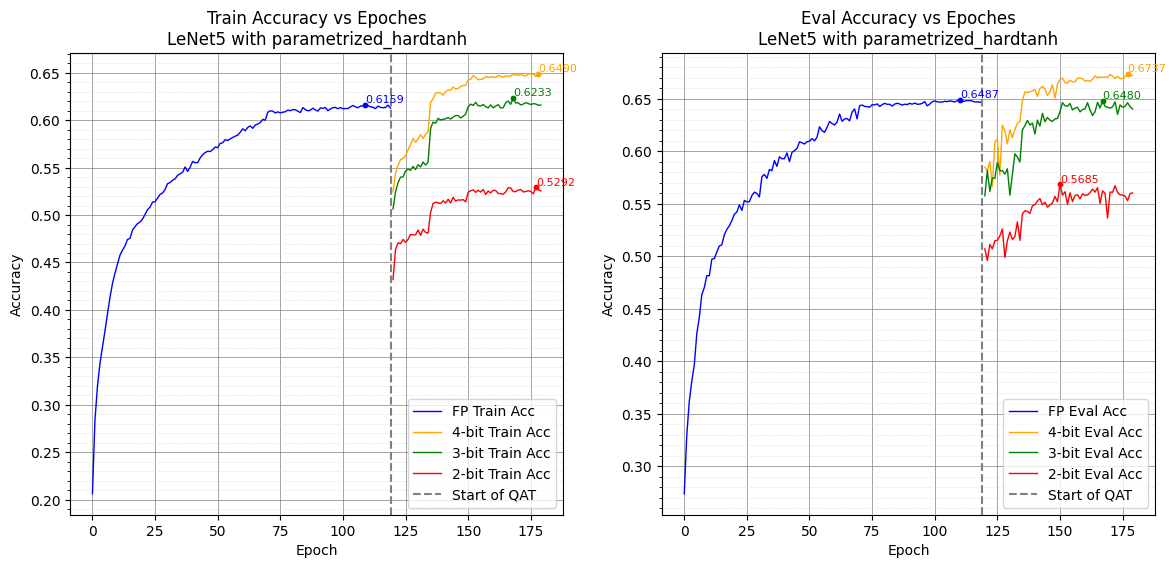

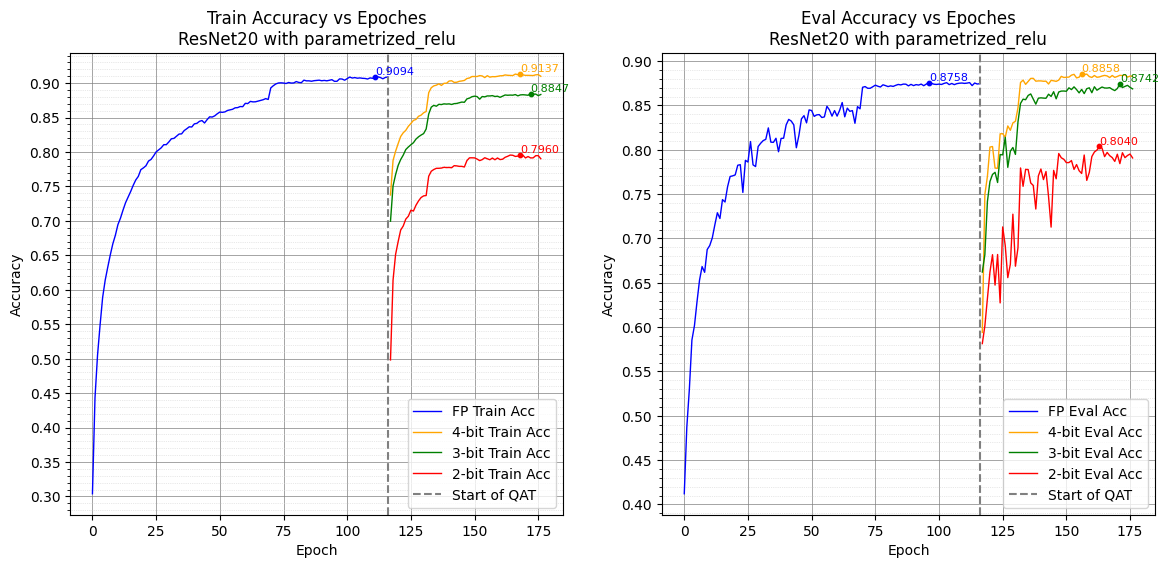

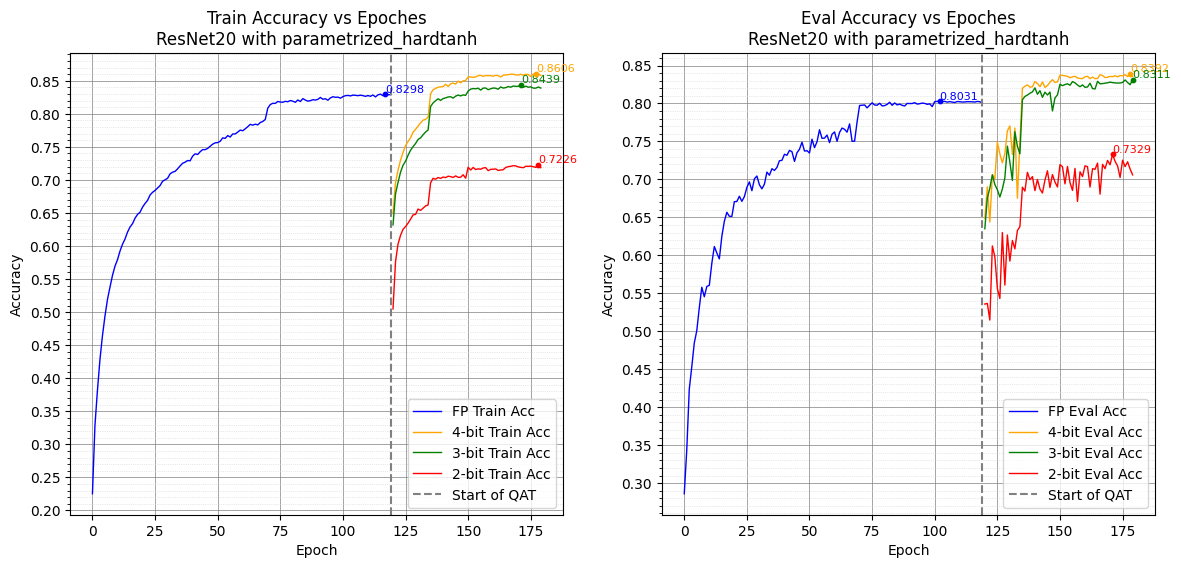

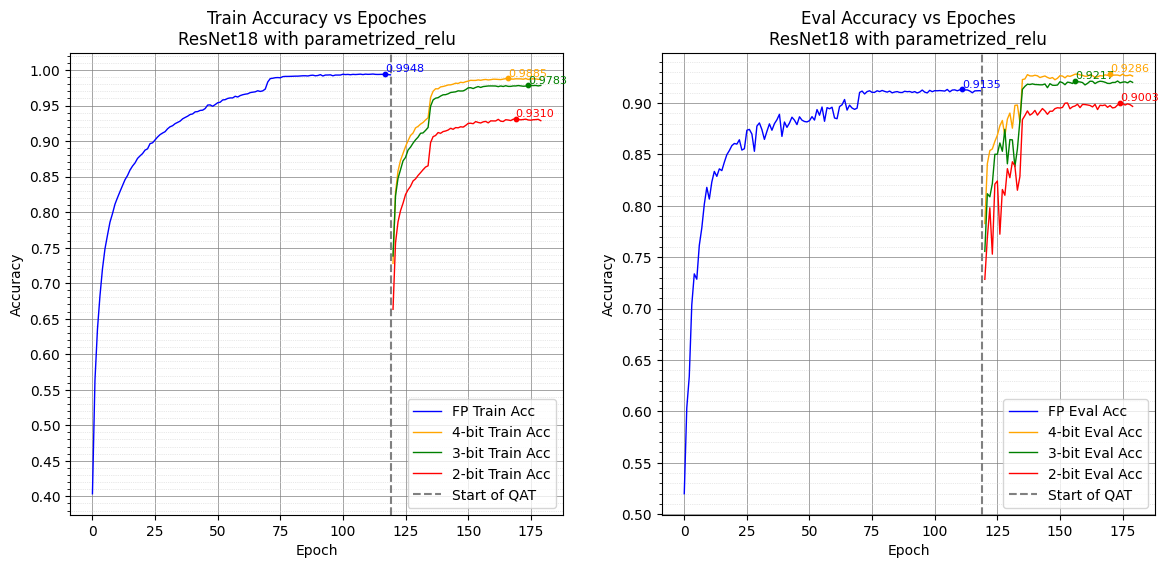

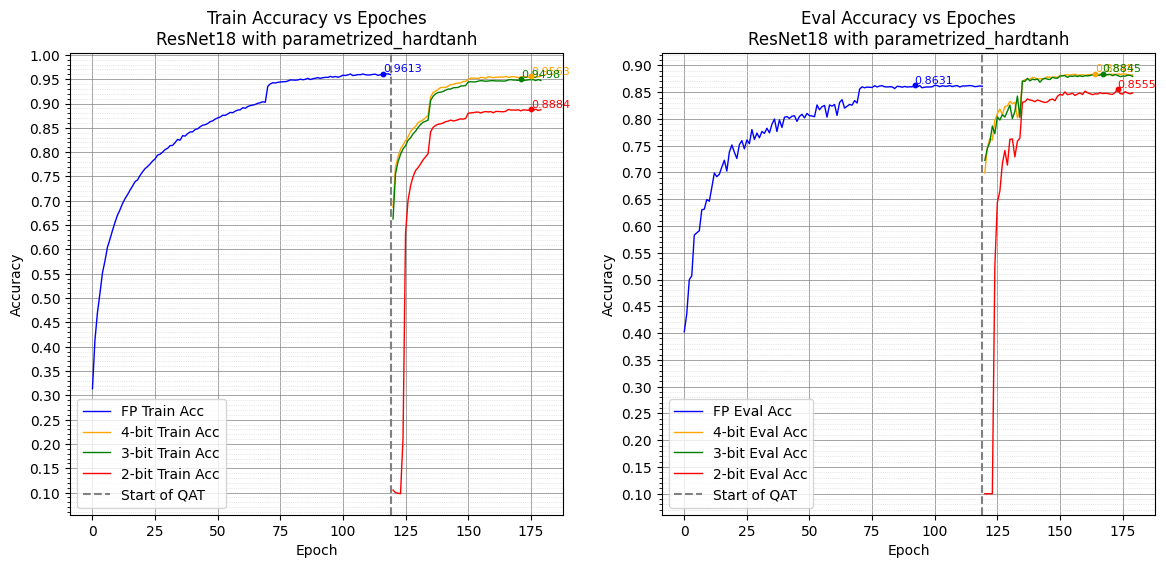

In [24]:
plot_comparisons(activations=["parametrized_relu", "parametrized_hardtanh"])

#### Сравним параметризованные модели с непараметризованными "соседями"

In [25]:
def plot_qat_comparison(
    parametrized_act,
    regular_act,
    logs_dir="raw_np",
    param_colors=["#1F77B4", "#2CA02C", "#D62728"],
    regular_colors=["#87CEEB", "#98DF8A", "#FF9896"],
):
    architectures = ["LeNet5", "ResNet20", "ResNet18"]
    bit_widths = [4, 3, 2]

    for arch in architectures:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        for act, colors in zip(
            [parametrized_act, regular_act], [param_colors, regular_colors]
        ):
            # Quantized models plots
            for bits, color in zip(bit_widths, colors):
                quant_file = os.path.join(
                    logs_dir,
                    f"{arch}_{act}_quantized_{bits}_bits",
                    "training_stats.npz",
                )
                if os.path.exists(quant_file):
                    quant_data = np.load(quant_file)
                    quant_epochs = quant_data["epoch"]
                    quant_eval_acc = quant_data["eval_acc"]
                    quant_train_acc = quant_data["train_acc"]
                    ax1.plot(
                        quant_epochs,
                        quant_train_acc,
                        label=f"{bits}-bit Train Acc ({act})",
                        color=color,
                        linewidth=2,
                    )
                    ax2.plot(
                        quant_epochs,
                        quant_eval_acc,
                        label=f"{bits}-bit Eval Acc ({act})",
                        color=color,
                        linewidth=2,
                    )

                    highlight_maximum_point(
                        ax1, quant_train_acc, quant_epochs, color=color
                    )
                    highlight_maximum_point(
                        ax2, quant_eval_acc, quant_epochs, color=color
                    )
                else:
                    print(f"File {quant_file} was not found.")

        ax1.set_title(f"Train Accuracy\n{arch}: {parametrized_act} vs {regular_act}")
        ax2.set_title(f"Eval Accuracy\n{arch}: {parametrized_act} vs {regular_act}")
        for ax in [ax1, ax2]:
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Accuracy")

            ax.yaxis.set_major_locator(MultipleLocator(0.05))
            ax.yaxis.set_minor_locator(MultipleLocator(0.01))
            ax.grid(which="major", linestyle="-", linewidth=0.5, color="gray")
            ax.grid(which="minor", linestyle=":", linewidth=0.5, color="lightgray")
            ax.legend(loc="best", fontsize=10)

        plt.show()

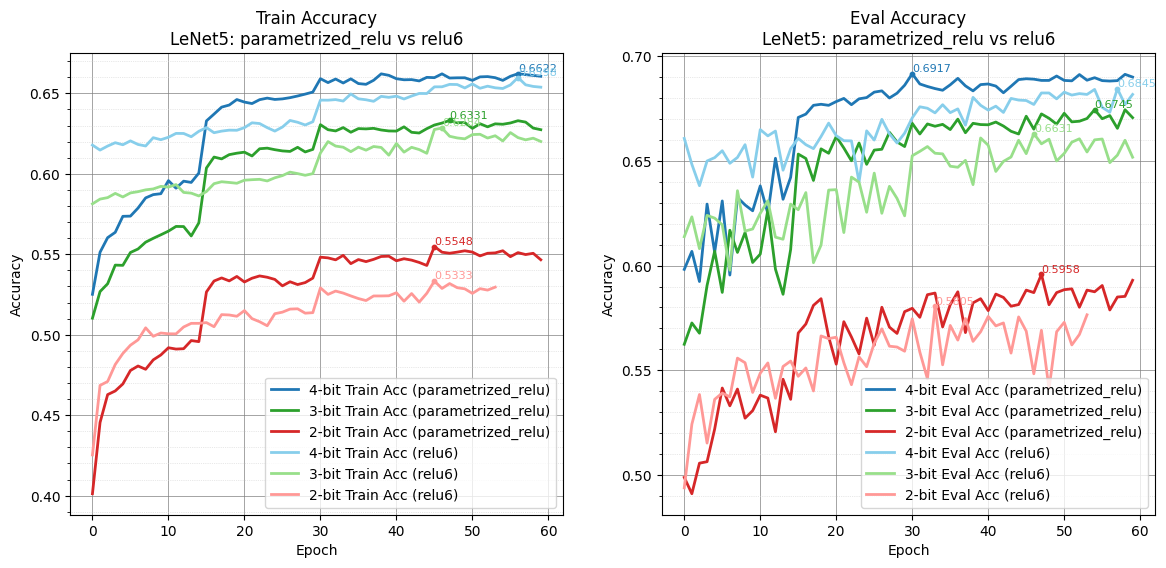

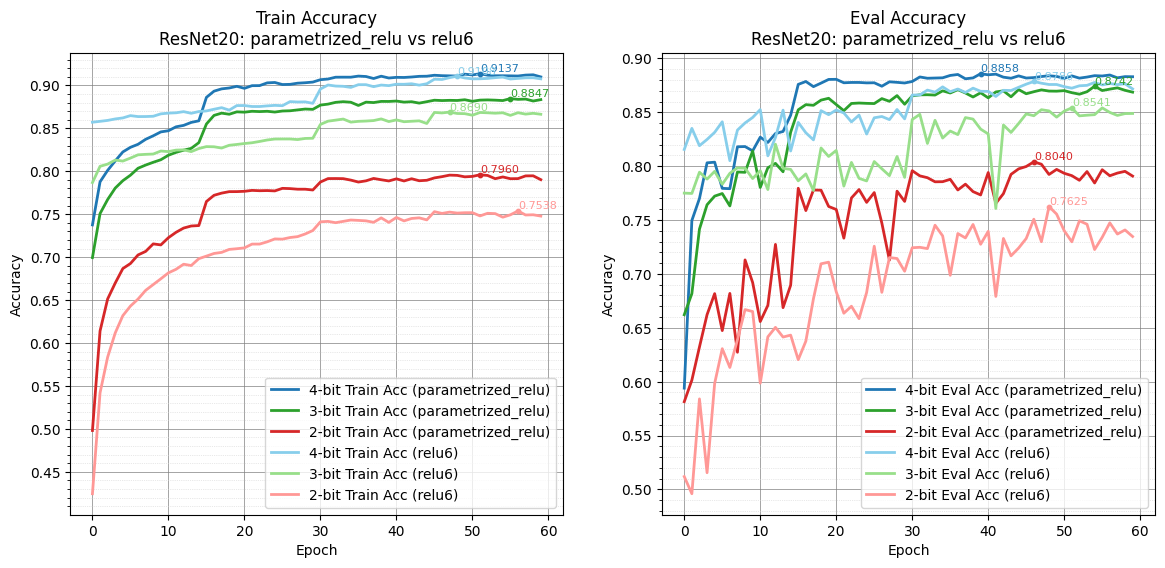

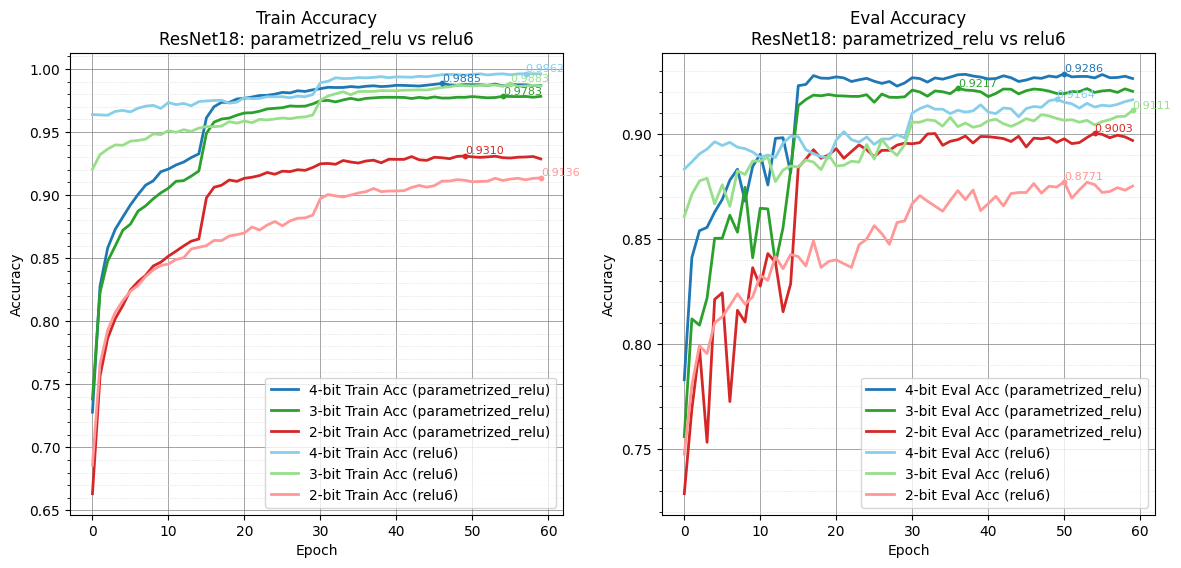

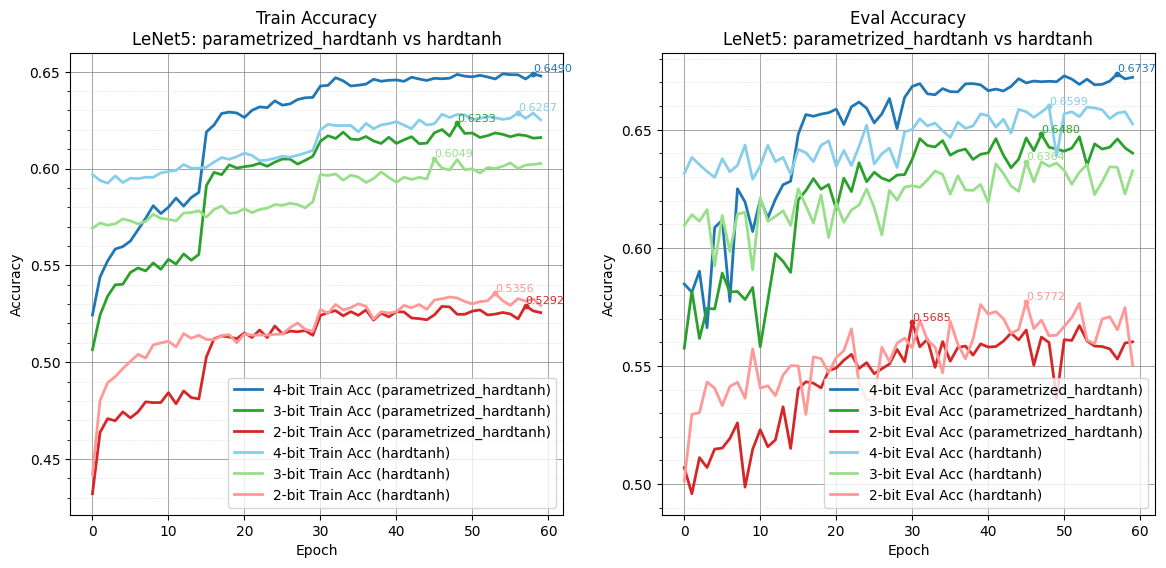

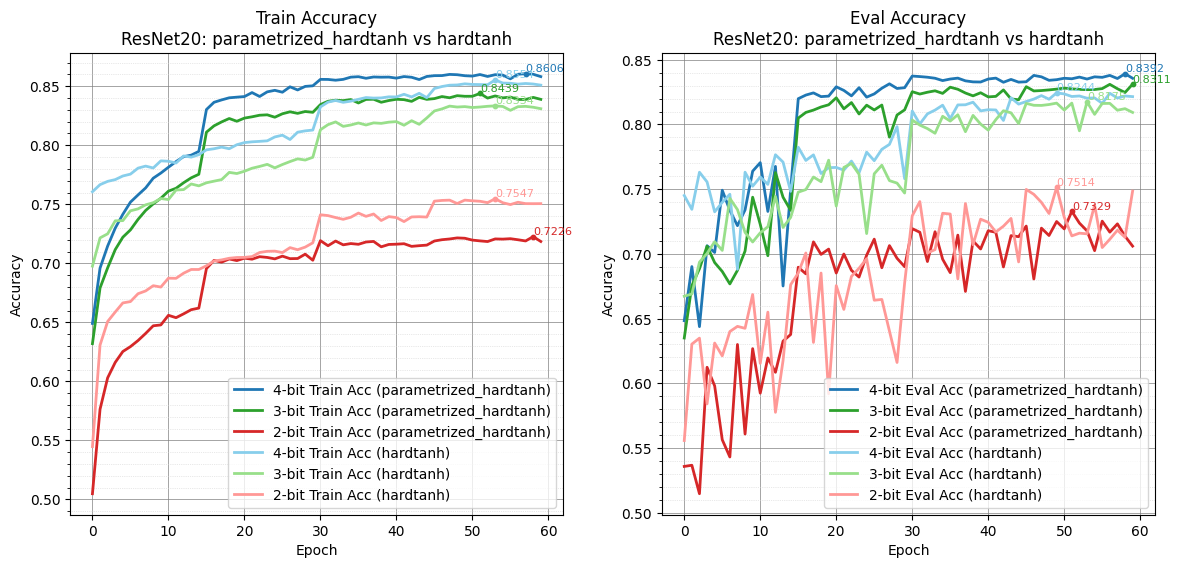

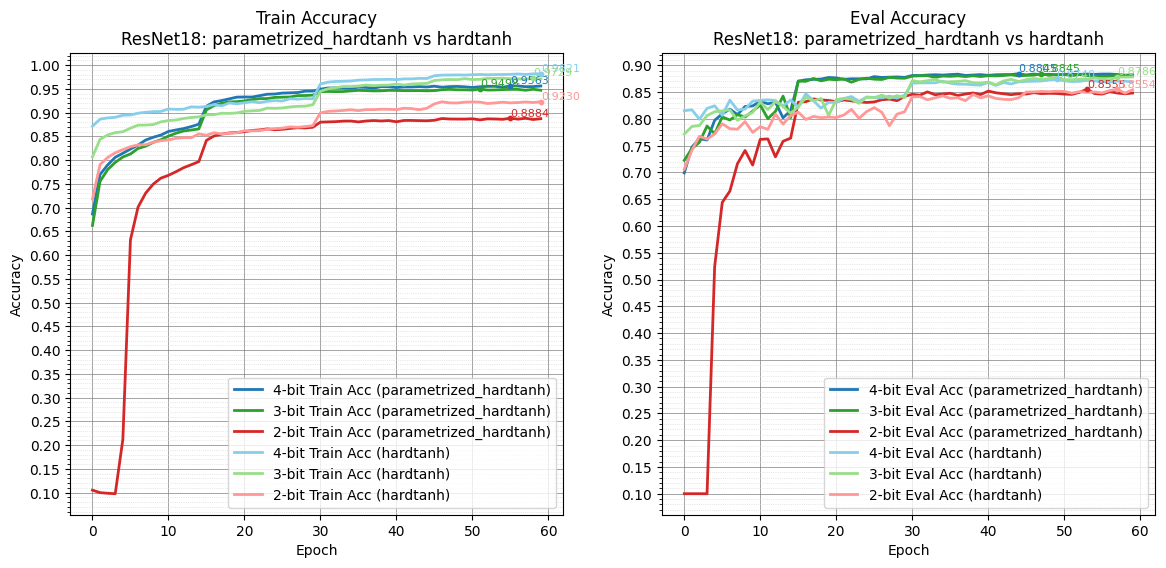

In [26]:
plot_qat_comparison("parametrized_relu", "relu6")
plot_qat_comparison("parametrized_hardtanh", "hardtanh")

Для `ParametrizedReLU` заметим, что параметризованная версия выигрывает у обычной всегда.

Для `ParametrizedHardtanh` отмечу, что параметризация дает заметное преимущество при квантовании до 3 и 4 бит. При квантовании до 2 бит, как было замечено ранее, `ParametrizedHardtanh` может уступать обычному.

Также общая тенденция - при параметризации, `Eval Accuracy` ведет себя стабильнее, чем с обычными функциями (менее резкие скачки под конец QAT). Вероятно, это связано с тем, что в параметризованном случае параметры квантования целиком определяются с помощью $\alpha$, который также контролирует и распределение самих активаций. В то время как в непараметризованном случае - функция активации с фиксированным отрезком значений, после которой происходит квантование, параметры для которого (масштаб и отступ) определяются из статистики значений активации, которая наблюдалась на обучаемой выборке (а значит, они могут хуже подходить для валидационной)    

#### Поведение обучаемых параметров

Отмечу, что оптимальное значение параметра зависит от слоя:

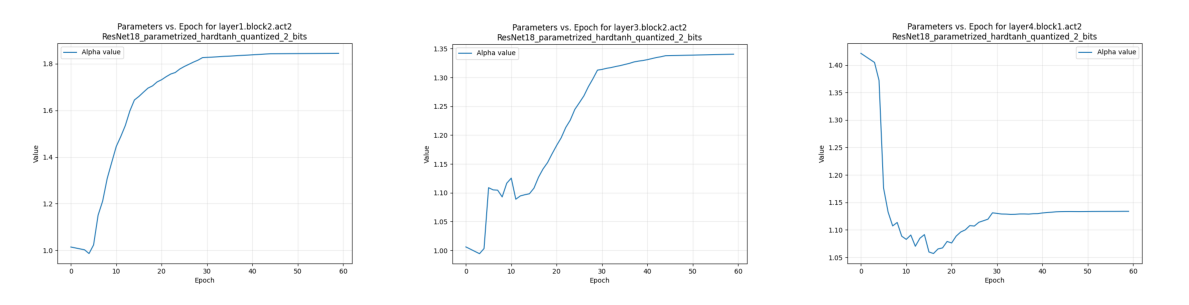

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


first = mpimg.imread('plots/ResNet18_parametrized_hardtanh_quantized_2_bits/activations_parameters/layer1.block2.act2.png')
second = mpimg.imread('plots/ResNet18_parametrized_hardtanh_quantized_2_bits/activations_parameters/layer3.block2.act2.png')
third = mpimg.imread('plots/ResNet18_parametrized_hardtanh_quantized_2_bits/activations_parameters/layer4.block1.act2.png')

fig, axes = plt.subplots(1, 3, figsize=(12, 8))

axes[0].imshow(first)
axes[0].axis('off')

axes[1].imshow(second)
axes[1].axis('off')

axes[2].imshow(third)
axes[2].axis('off')

plt.tight_layout()
plt.show()